In [2]:
# Mask-based Curve Detection Model - PyTorch Implementation
# Updated by ChatGPT - May 2025

import os
import json
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# 1. Dataset
# =========================

from PIL import Image
class MaskDataset(Dataset):
    def __init__(self, root_dir, max_lines=3, img_size=(128, 512)):
        self.data_dir = os.path.join(root_dir, "data")
        self.labels_dir = os.path.join(root_dir, "labels")
        self.max_lines = max_lines
        self.img_size = img_size

        self.sample_names = [
            os.path.splitext(f)[0]
            for f in os.listdir(self.data_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
        ]
        self.sample_names.sort()

    def __len__(self):
        return len(self.sample_names)

    def __getitem__(self, idx):
        base_name = self.sample_names[idx]
        data_path = os.path.join(self.data_dir, base_name + ".png")
        data_img = Image.open(data_path).convert("F").resize(self.img_size, resample=Image.BILINEAR)
        matrix = np.array(data_img, dtype=np.float32)
        
        if np.max(matrix) > 0:
            matrix = matrix / np.max(matrix)
        matrix = torch.tensor(matrix).unsqueeze(0)

        masks, types, valid = [], [], []
        for i in range(self.max_lines):
            label_name = f"{base_name}_{i:02d}.png"
            label_path = os.path.join(self.labels_dir, label_name)
            if os.path.exists(label_path):
                label_img = Image.open(label_path).convert("L").resize(self.img_size, resample=Image.NEAREST)
                mask_array = np.array(label_img, dtype=np.uint8)
                if np.max(mask_array) > 0:
                    mask_array = mask_array / np.max(mask_array)
                masks.append(mask_array)
                types.append(i)
                valid.append(1)
            else:
                masks.append(np.zeros(self.img_size, dtype=np.uint8))
                types.append(0)  # 填充值，训练时会被忽略
                valid.append(0)

        return {
            'image': matrix,
            'masks': torch.tensor(np.stack(masks), dtype=torch.float32),
            'types': torch.tensor(types, dtype=torch.long),
            'valid': torch.tensor(valid, dtype=torch.bool)
        }

In [3]:
class MaskTypeTransformer(nn.Module):
    def __init__(self, in_channels=1, max_lines=3, embed_dim=256):
        super().__init__()
        self.num_types = num_types = self.max_lines= max_lines

        # CNN feature extractor
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),  # [B, 1, 128, 128] -> [B, 32, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 64, 64]
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 32, 32]
            nn.Conv2d(64, embed_dim, 3, padding=1),
            nn.ReLU(),        # [B, 256, 32, 32]
        )

        # Transformer encoder over flattened spatial features
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8,batch_first=True)  # ✅ 添加这个参数
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Mask head - Upsample to (512, 128)
        self.mask_head = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),         # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, max_lines, kernel_size=2, stride=2),   # 128x128 -> 256x256
            nn.ReLU(),
            nn.Conv2d(max_lines, max_lines, kernel_size=3, padding=1),
            nn.Upsample(size=(512, 128), mode="bilinear", align_corners=False)  # 输出尺寸统一
        )

        # Type head - predict [max_lines, num_types]
        self.type_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),  # [B, C, 1, 1] -> [B, C]
            nn.Linear(embed_dim, max_lines * num_types)
        )

    def forward(self, x):
        feats = self.backbone(x)  # [B, 256, 32, 32]
        B, C, H, W = feats.shape
        flattened = feats.view(B, C, -1).permute(2, 0, 1)  # [HW, B, C]
        encoded = self.transformer(flattened).permute(1, 2, 0).view(B, C, H, W)

        masks = self.mask_head(encoded)  # [B, max_lines, 512, 128]

        types = self.type_head(encoded)  # [B, max_lines * num_types]
        types = types.view(B, self.max_lines, self.num_types)  # [B, max_lines, num_types]
        return masks, types


In [4]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # 先做sigmoid
        pred_flat = pred.view(pred.size(0), -1)
        target_flat = target.view(target.size(0), -1)
        intersection = (pred_flat * target_flat).sum(1)
        union = pred_flat.sum(1) + target_flat.sum(1)
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def mask_loss(pred_masks, pred_types, gt_masks, gt_types, mask_weight=1.0, type_weight=1.0):
    """
    pred_masks: [B, max_lines, H, W]
    pred_types: [B, max_lines, num_types]
    gt_masks:   [B, max_lines, H, W]
    gt_types:   [B, max_lines], 可能含 -1（表示无效标签）
    """
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss()
    B, max_lines, H, W = pred_masks.shape

    # --------------------------
    # 1. 掩膜损失（逐个 mask 计算）
    # --------------------------
    pred_masks_flat = pred_masks.view(B * max_lines, H, W)
    gt_masks_flat = gt_masks.view(B * max_lines, H, W)

    mask_loss_val = bce(pred_masks_flat, gt_masks_flat) + dice(pred_masks_flat, gt_masks_flat)

    # --------------------------
    # 2. 类型分类损失（屏蔽无效类型）
    # --------------------------
    B, N, C = pred_types.shape
    pred_types_flat = pred_types.view(B * N, C)     # [B*N, num_types]
    gt_types_flat = gt_types.view(B * N)            # [B*N]

    # 仅使用有效标签参与 CrossEntropy 计算
    valid = gt_types_flat != -1
    if valid.sum() > 0:
        ce_loss = F.cross_entropy(pred_types_flat[valid], gt_types_flat[valid])
    else:
        ce_loss = torch.tensor(0.0, device=pred_masks.device)

    # --------------------------
    # 3. 总损失
    # --------------------------
    total_loss = mask_weight * mask_loss_val + type_weight * ce_loss
    return total_loss


def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for dict1 in loader:
        x, y_masks, y_types, valid = dict1['image'], dict1['masks'], dict1['types'], dict1['valid']

        x = x.to(device)
        y_masks = y_masks.to(device)
        y_types = y_types.to(device)

        pred_masks, pred_types = model(x)
        loss = mask_loss(pred_masks, pred_types, y_masks, y_types)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [5]:
# =========================
# 5. Visualization
# =========================

def visualize_masks(matrix, pred_masks, threshold=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
    pred_masks = torch.sigmoid(pred_masks)
    for i in range(pred_masks.shape[0]):
        mask = pred_masks[i] > threshold
        if mask.sum() > 0:
            ax.contour(mask.cpu().numpy(), levels=[0.5], colors=[f"C{i}"])
    ax.set_title("Predicted Masks")
    plt.show()

In [6]:
# =========================
# 6. Run Example
# =========================

data_dir = "/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/dataset_png/train"
dataset = MaskDataset(data_dir, max_lines=5)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


model = MaskTypeTransformer(max_lines=5).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# model_path = 'checkpoints/png/model_lasted.pth'
# model.load_state_dict(torch.load(model_path, weights_only=True))
# optimizer_path = 'checkpoints/png/optimizer_lasted.pth'
# optimizer.load_state_dict(torch.load(optimizer_path, weights_only=True))

history_loss = []
for epoch in range(0, 10):
    loss = train(model, loader, optimizer, device="cuda")
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")
        history_loss.append([epoch, loss])
    if epoch % 20 == 0:
        # 保存模型权重和优化器状态，便于后续加载和复现实验
        save_dir = "checkpoints/png3"
        os.makedirs(save_dir, exist_ok=True)
        model_path = os.path.join(save_dir, f"model_{epoch:05d}.pth")
        optimizer_path = os.path.join(save_dir, f"optimizer_{epoch:05d}.pth")
        torch.save(model.state_dict(), model_path, )
        torch.save(optimizer.state_dict(), optimizer_path)

history_loss = np.array(history_loss)

# 保存模型权重和优化器状态，便于后续加载和复现实验
save_dir = "checkpoints/png2"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "model_lasted.pth")
optimizer_path = os.path.join(save_dir, f"optimizer_lasted.pth")
torch.save(model.state_dict(), model_path, )
torch.save(optimizer.state_dict(), optimizer_path)


ValueError: all input arrays must have the same shape

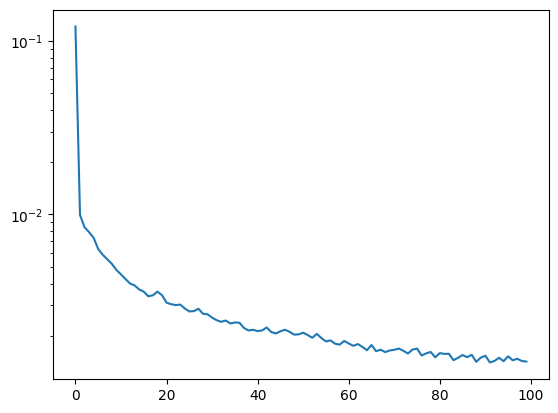

In [7]:
plt.plot(history_loss[:, 0], history_loss[:, 1])
plt.yscale('log')
plt.show()


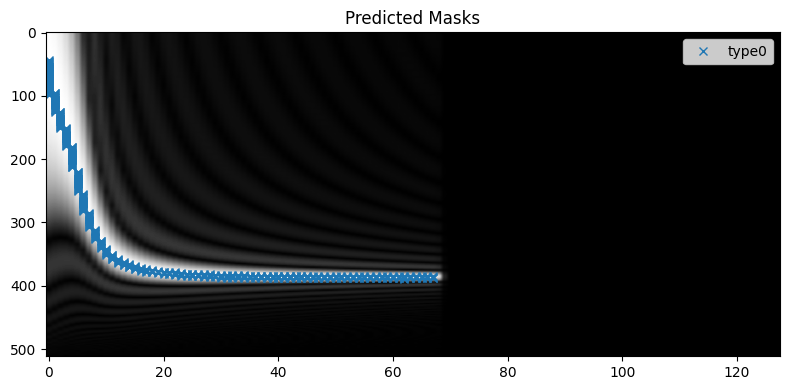

In [8]:
data_dir = "/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/dataset_png/test"
dataset = MaskDataset(data_dir)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 可视化最后一个 batch 的第一个样本
x, y_masks, y_types = next(iter(loader))

i = 2
model.eval()
with torch.no_grad():
    pred_masks, pred_types = model(x.cuda())
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

matrix = x[i]
pred_mask = pred_masks[i]
pred_type = pred_types[i]
threshold = 0.05

ax.imshow(matrix.squeeze().cpu(), cmap='gray', aspect='auto')
pred_mask = torch.sigmoid(pred_mask)
pred_type = pred_type.argmax(dim=1)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

legend_elements = []

styles = ['x', '+', 'x']
for i in range(pred_mask.shape[0]):
    mask = pred_mask[i] > threshold
    if mask.sum() > 0:
        coords = torch.nonzero(mask, as_tuple=False).cpu().numpy()
        if coords.size > 0:
            ax.plot(coords[:, 1], coords[:, 0], 
                    styles[pred_type[i]], 
                    color=f"C{i}", 
                    label=f"type{pred_type[i]}")
            legend_elements.append(Line2D([0], [0], color=f"C{i}", marker=styles[pred_type[i]], linestyle='None', label=f"type{pred_type[i]}"))

ax.set_title("Predicted Masks")
ax.legend(handles=legend_elements)
fig.tight_layout()
plt.show()

In [9]:
pred_type[i]

tensor(4, device='cuda:0')

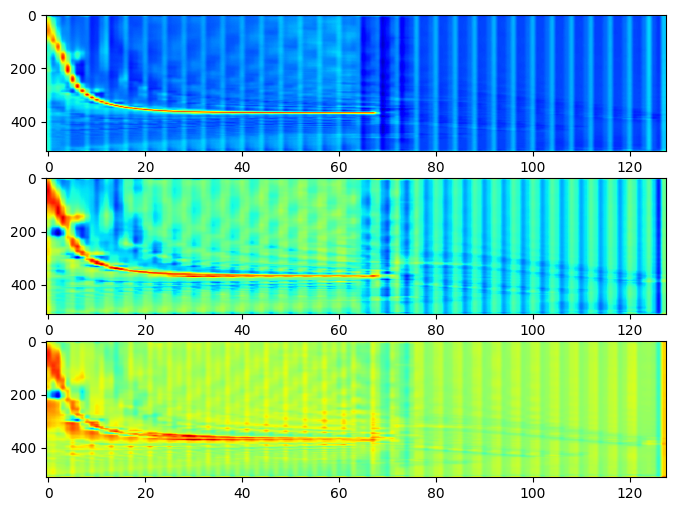

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].imshow(pred_masks[i][0].squeeze().cpu(), cmap='jet', aspect='auto')
axes[1].imshow(pred_masks[i][1].squeeze().cpu(), cmap='jet', aspect='auto')
axes[2].imshow(pred_masks[i][2].squeeze().cpu(), cmap='jet', aspect='auto')

In [11]:
y_masks[i][0].shape

torch.Size([512, 128])

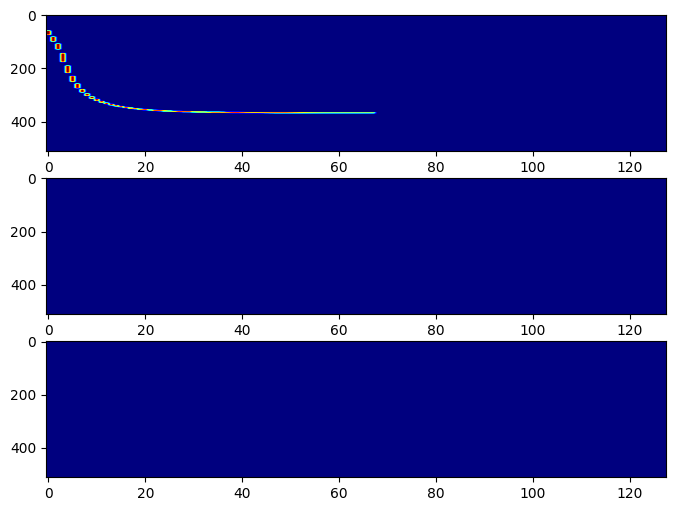

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].imshow(y_masks[i][0].squeeze().cpu(), cmap='jet', aspect='auto')
axes[1].imshow(y_masks[i][1].squeeze().cpu(), cmap='jet', aspect='auto')
axes[2].imshow(y_masks[i][2].squeeze().cpu(), cmap='jet', aspect='auto')